#Load, format cleaned data:

In [30]:
import pandas as pd
import numpy as np
import os

data = pd.read_csv('/Users/fineiskid/Desktop/Healthcare_Prediction/data/frank_clean_data.csv', na_values='na',
                  keep_default_na = True)
data.head(5)

aa_primarykey      agep     hincp        np       pap       veh      wkhp  \
0              1  1.714639 -0.806771 -0.694199 -0.074189 -0.055156       NaN   
1              2  0.860682  0.084138 -0.694199 -0.074189 -0.055156       NaN   
2              3 -0.548348 -0.644095 -0.126756 -0.074189 -0.949111  0.159869   
3              4  0.817984 -0.381016 -0.694199 -0.074189 -0.055156  0.159869   
4              5  0.860682 -0.360681 -0.694199 -0.074189 -0.055156       NaN   

   hicov  rwat  cit  fs  mar  sex  dis  rac1p  mil  sch  wif  mv  cow  
0      1     1    4   0    1    1    1      1    3    1    0   6  NaN  
1    NaN     1    1   0    1    0    0      1    5    1    1   3    1  
2      0     1    1   0    5    1    0      1    5    1    0   1    1  
3    NaN     1    1   0    1    1    0      1    5    1    1   6    5  
4    NaN     1    1   0    3    0    0      1    5    1    1   5    3

#Let's separate people with healthcare coverage (training data) from those without (test data), and then grab all of the clean training data (no missing values). Also, make sure Python knows you have categorical data.

#######Note: 
First we need to find the locations of the NA data and then separate, as it's really hard to identify NA values once we make the *hicov* data categorical...

In [31]:
#Separate known health coverage from unknown health coverage
data_known = data.loc[~np.isnan(data.hicov)] #Eventual training data
data_unknown = data.loc[np.isnan(data.hicov)] #Eventual test data

train_data = data_known.dropna(axis = 0)

test_data = data_unknown[data_unknown.columns[data_unknown.columns != 'hicov']].dropna(axis = 0)
test_data['hicov'] = np.nan

In [32]:
#Make categorical data astype('category')
train_data.ix[:,"cit"] = train_data.ix[:,"cit"].astype("category")
train_data.ix[:,"dis"] = train_data.ix[:,"dis"].astype("category")
train_data.ix[:,"fs"] = train_data.ix[:,"fs"].astype("category")
train_data.ix[:,"hicov"] = train_data.ix[:,"hicov"].astype("category")
train_data.ix[:,"mar"] = train_data.ix[:,"mar"].astype("category")
train_data.ix[:,"rac1p"] = train_data.ix[:,"rac1p"].astype("category")
train_data.ix[:,"rwat"] = train_data.ix[:,"rwat"].astype("category")
train_data.ix[:,"mil"] = train_data.ix[:,"mil"].astype("category")
train_data.ix[:,"sex"] = train_data.ix[:,"sex"].astype("category")

test_data.ix[:,"cit"] = test_data.ix[:,"cit"].astype("category")
test_data.ix[:,"dis"] = test_data.ix[:,"dis"].astype("category")
test_data.ix[:,"fs"] = test_data.ix[:,"fs"].astype("category")
test_data.ix[:,"hicov"] = test_data.ix[:,"hicov"].astype("category")
test_data.ix[:,"mar"] = test_data.ix[:,"mar"].astype("category")
test_data.ix[:,"rac1p"] = test_data.ix[:,"rac1p"].astype("category")
test_data.ix[:,"rwat"] = test_data.ix[:,"rwat"].astype("category")
test_data.ix[:,"mil"] = test_data.ix[:,"mil"].astype("category")
test_data.ix[:,"sex"] = test_data.ix[:,"sex"].astype("category")

#save train/test data
train_data.to_csv(os.path.join(os.getcwd(), '..', 'data', 'train_data.csv'), index = False)
test_data.to_csv(os.path.join(os.getcwd(), '..', 'data', 'test_data.csv'), index = False)

/Users/fineiskid/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


#Begin with a Naive Bayes model
Let's see what sort of successful classification rates we can get with a simple Gaussian Naive Bayes model. **Note:** this model only works with continuous variables.

We'll use a multinomial Naive Bayes model separately for the categorical features.

Remember Bayes' Law? I don't. We're interested in $P(Class_{k}| \text{ } row.of.data)$, the probability that a certain row (a set of obvservations, a vector, what have you) corresponds to a member of class $k$. This is called the **posterior probability** which is given by: <p> $$P(Class_{k}| \text{ } row.of.data) = \frac{P(Class_{k} \text{ and } \text{ } row.of.data)}{P(\text{} row.of.data)}$$

More formally, a 'row.of.data' is a vector, $\vec{x} = (x_{1}, x_{2}, \ldots, x_{n})$.

Traditionally speaking, the joint probability of $(x_{1}, x_{2}, \ldots, x_{n})$ *and* being in $Class_{k}$ is <p> $$P(C_{k}, x_{1}, x_{2}, \ldots, x_{n}) = P(C_{k})P(x_{1}|C_{k})P(x_{2}|C_{k}, x_{1})\cdots P(x_{n} | C_{k}, x_{1},x_{2},\ldots x_{n})$$

What makes this *naive* is that we assume each conditional probability is independent! That is, $P(x_{i} | C_{k}, x_{1}, \ldots, x_{i}) = P(x_{i} | C_{k})$. Therefore, we can rewrite the posterior as being proportional to the product of the (*naively independent*) conditional probabilities: <p> 
$$P(C_{k}| x_{1}, x_{2}, \ldots, x_{n}) \propto P(C_{k})\Pi_{i = 1}^{n}P(x_{i}|C_{k})$$ The goal of Naive Bayes is to maximize this posterior probability.

<p>
<p>
What makes this *Gaussian*? The independent conditional probabilities! That is, just separate each of the training data's continuous regressors, i.e. the columns, into their respective classes, find the mean and variance of each regressor's class, and **boom**, you can make a probability density function for the attribute $x_{i}$ given that it corresponds to a $\vec{x}$ being in class $k$:
<p>
$$P(x_{i}|C_{k}) = \frac{1}{\sqrt{2\pi \sigma_{c_{k}}^{2}}}e^{\frac{(x_{i}-\mu_{c_{k}})^{2}}{2\sigma_{c_{k}}^{2}}}$$



We mislabeled 5465 out of 36164 tested points for an error rate of 15.1117133061%.


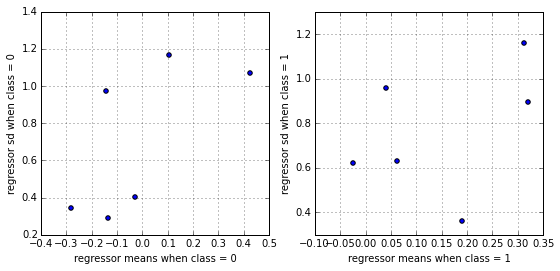

In [80]:
%matplotlib inline
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split

#get model object
gnb = GaussianNB()

#formulate target/data matrices. Must be np.arrays!
ct = ['agep', 'hincp', 'np', 'pap', 'veh', 'wkhp', 'hicov']
train_ct = train_data[ct[:-1]].as_matrix()
y = train_data[ct[-1]].as_matrix()

# Split data! test_size: the proportion of the dataset to include in the test split. Default is 0.25.
Xtrain, Xtest, ytrain, answer = train_test_split(train_ct,y, test_size = 0.33, random_state = 20)

gnbfit = gnb.fit(Xtrain, ytrain)
gnbpreds = gnb.predict(Xtest)

errorgnb = float(sum(gnbpreds != answer))/len(answer)*100
print('We mislabeled {0} out of {1} tested points for an error rate of {2}%.'.format(sum(gnbpreds != answer), len(answer), errorgnb))
#Not bad!!!

#there is one mean and one variance for each regressor for each class: 24 parameters total
#figure object
fig1 = plt.figure(figsize=(9, 4))
#axis object
ax = fig1.add_subplot(1,2,1)
ax.scatter(gnbfit.theta_[0,:], gnbfit.sigma_[0,:])
ax.set_xlabel('regressor means when class = 0'); ax.set_ylabel('regressor sd when class = 0')
ax.grid()
ax = fig1.add_subplot(1,2,2)
ax.scatter(gnbfit.theta_[1,:], gnbfit.sigma_[1,:])
ax.set_xlabel('regressor means when class = 1'); ax.set_ylabel('regressor sd when class = 1')
ax.grid()

## hashtag basic, let's fit a simple linear support vector machine classification model.
SVM doesn't scale well. For efficiency, let's just fit it/test it a small subset of the known training data.

In [47]:
import random
size = 12000

# for efficiency: select size-many samples from training_data.
samp = random.sample(range(train_data.shape[0]), size)

y = train_data.hicov.as_matrix()[samp]
columns = train_data.drop(['hicov', 'aa_primarykey'], axis = 1).columns
X = train_data.drop(['hicov', 'aa_primarykey'], axis = 1).as_matrix()[samp,:]

# Split data! test_size: the proportion of the dataset to include in the test split. Default is 0.25.
Xtrain, Xtest, ytrain, answer = train_test_split(X,y, test_size = 0.33, random_state = 20)

from sklearn.svm import SVC # "Support Vector Classifier"
clf = SVC(kernel='linear') #kernel can also be 'poly' or 'sigmoid' or 'rbf' (default) 
clf.fit(Xtrain, ytrain)

#distance from hyperplane, and predicted hicov vector for Xtest:
dist = clf.decision_function(Xtest)
pred = clf.predict(Xtest)

error_rate = sum(np.abs(pred-answer))/len(answer)
print('Prediction error rate = {0}%'.format(error_rate*100))

Prediction error rate = 13.3333333333%


##Next, let's fit a logistic regression model with L1 regularizer:
#####Why?
To potentially cut down the number of predictor variables, or at least not have a vector of huge coefficients, which indicates overfitting. Note that we're optimizing

$$min \text{ }||w||_{1} + C \sum log(exp(-y_{i}(X_{i}^{T} w + c) )+1)$$

Where **$log(exp(-y_{i}(X_{i}^{T} w + c) )+1)$** is the loss function. Bigger *C* implies less regularization (i.e. larger coefficients).

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold

#Can we pick a good regularization coefficient?
Cs = [0.01, 0.1, 0.5, 1, 50, 1000]
for c in Cs:
    logreg = LogisticRegression(penalty = 'l1', C = c)
    logreg.fit(Xtrain, ytrain)

    pred_logreg = logreg.predict(Xtest)
    decision = logreg.decision_function(Xtest)

    error_rate = sum(np.abs(pred_logreg-answer))/len(answer)
    w_l1 = np.sum(np.abs(logreg.coef_))
    print('C = {0}; ||w|| = {1}; Prediction error rate = {2}%'.format(c, w_l1, error_rate*100)) 

#Let's validate:
error_vec = np.zeros(200)
logreg = LogisticRegression(penalty = 'l1', C = 0.1)
logreg.fit(Xtrain, ytrain)
for jj in range(200):
    samp = random.sample(range(train_data.shape[0]), size)
    y = train_data.hicov.as_matrix()[samp]
    X = train_data.drop(['hicov', 'aa_primarykey'], axis = 1).as_matrix()[samp,:]
    Xtrain, Xtest, ytrain, answer = train_test_split(X,y, test_size = 0.33, random_state = 20)
    pred_logreg = logreg.predict(Xtest)
    error_vec[jj] = sum(np.abs(pred_logreg-answer))/len(answer)

print('When C = 0.1, RMSE = {0}.'.format(np.sqrt(np.sum(error_vec**2)/len(error_vec))))
print('When C = 0.1, mean error = {0}'.format(np.mean(error_vec)))
    

C = 0.01; ||w|| = 2.01808826671; Prediction error rate = 11.9696969697%
C = 0.1; ||w|| = 4.61916375926; Prediction error rate = 11.7676767677%
C = 0.5; ||w|| = 5.37410263702; Prediction error rate = 11.7424242424%
C = 1; ||w|| = 5.50940548906; Prediction error rate = 11.8181818182%
C = 50; ||w|| = 5.64828065576; Prediction error rate = 11.7424242424%
C = 1000; ||w|| = 5.65824086626; Prediction error rate = 11.7424242424%
When C = 0.1, RMSE = 0.125963971284.
When C = 0.1, mean error = 0.125839646465


#What's for dinner? Decision trees and random forests.

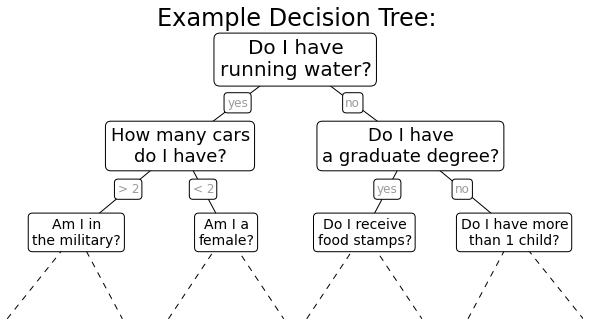

In [12]:
%matplotlib inline
import fig_Jake
import matplotlib.pyplot as plt

fig_Jake.plot_example_decision_tree()

### Decision trees: what's under the hood?

We build a *Boolean function* that successively partitions the data into 'yes healthcare' and 'no healthcare.' 

######Decision trees have *interior nodes* and *leaves*:
- Interior nodes correspond to a particular variable, and with discrete or categorical data, the branching of interior nodes is obvious ('Are you in the military?', 'Do you have a dog?', etc.). Splitting of interior nodes is less obvious for continous features, because you need to chose where to partition ('What is your income?', etc.).
- Leaves correspond to a decision. For example, perhaps everyone in the training data that has more than 3 cars, makes \$70000 per year, and is over age 60 has healthcare coverage. Then this can be modeled with a 3-level path, dead-ending at a leaf of 'yes healthcare.'

######Drawbacks/caveats:
- We could potentially build a decision tree with $2^{n}$ leaves, where every datapoint leads to its own dead-end!
- Tendancy to overfit training data if the number of nodes used to build the model is too high. We can control this with **depth** parameter, amongst others.

######Basic premise:
- For each node, we want to pick the feature $X_{j}$ resulting in the greatest **information gain**. Information gain quantifies how much $X_{j}$ tells us about the target values $Y$. 
- Information gain can be based on **entropy**, which is one way of measuring the uncertainty of a variable. For example, if I have a coin where both sides are heads, then P(tails) = 0 and P(heads) = 1. There is no uncertainty. How can one random variable be more uncertain than another? If P(tails) = 0.5 and P(heads) = 0.5, then the coin flip is surely more of an uncertain random variable than when P(tails) = 0.9 and P(heads) = 0.1, because we'll aways bet on tails.
- **information gain** = the change in entropy between two nodes on a tree, given that the first node was reached. We want to maximize the information gained about the target $Y$ given that some $X_{j}$ has happened:
$$IG(X_{j}) = Entropy(Y) - Entropy(Y|X_{j})$$ *-------------------------------"How much of a surprise $Y$ is even after $X_{j}$ has occured"----------------------------------*
- *ID3 Algorithm*: For each class of target variable (like $Y = 1$ or $Y = 0$), pick feature $X_{j}$ such that the information gained about $Y$ is maximum. Make a node, continue. 

######How to use?
- Use **sklearn.tree.DecisionTreeClassifier**. Check out parameters at *http://bit.ly/1T5sf92*


In [87]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import cross_val_score

clf1 = DecisionTreeClassifier(criterion = 'entropy', max_features = 'sqrt', max_depth = None)
print('TREE 1:')
print('Mean prediction score: {0}%'.format(np.mean(cross_val_score(clf1, X, y, cv = 50))*100))
print('Max depth = {0}'.format(clf1.fit(X,y).tree_.max_depth))

clf2 = DecisionTreeClassifier(criterion = 'entropy', max_features = None, max_depth = 10)
print('TREE 2:')
print('Mean prediction score: {0}%'.format(np.mean(cross_val_score(clf2, X, y, cv = 50))*100))
print('Max depth = {0}'.format(clf2.fit(X,y).tree_.max_depth))

clf3 = DecisionTreeClassifier(criterion = 'entropy', max_features = None, max_depth = None)
print('TREE 3:')
print('Mean prediction score: {0}%'.format(np.mean(cross_val_score(clf3, X, y, cv = 50))*100))
print('Max depth = {0}'.format(clf3.fit(X,y).tree_.max_depth))  

#most important features, from least important to most:
imps = clf2.tree_.compute_feature_importances()
print('The most important features, in ascending order:')
colnames[sorted(range(len(imps)),key=imps.__getitem__)]

TREE 1:
Mean prediction score: 82.2336349879%
Max depth = 35
TREE 2:
Mean prediction score: 86.041588251%
Max depth = 10
TREE 3:
Mean prediction score: 82.2915496218%
Max depth = 35


Index([u'rwat', u'dis', u'mil', u'pap', u'sex', u'fs', u'sch', u'rac1p',
       u'wif', u'cow', u'veh', u'np', u'mv', u'wkhp', u'cit', u'mar', u'agep',
       u'hincp'],
      dtype='object')

###How can we see what's going on in the tree?

Need to fit a classifier object with data *and then* access attributes of tree via: $tree = clf.tree_$
Some things you can see:
- **tree.node_count**: number of many nodes (how complex is our tree?)
- **tree.max_depth**: how many levels of nodes are there, how tall is the tree?
- **tree.compute_feature_importances()** : if the feature is randomly permuted, how much accuracy does the tree lose? If not that much, the feature isn't that important.
- **tree.feature**: which features were used at each node
- **tree.threshold**: threshold values used at each node to split the specified threshold
- **tree.value**: for each node, state how many paths ended up being a node. I.e. [5,0] indicates that on some node, 5 observations answered 'no' and became part of a leaf, meaning they were classified as either a 'yes' or 'no' healthcare.


###Random Forests: because the average of lots of decision trees from slightly perturbed data will be less overfitted than just one decision tree.
- Very easy to implement! We just need to enter **n_estimators**, a.k.a. the number of decision tree classifiers we want to use. 

In [196]:
from sklearn.ensemble import RandomForestClassifier
clf_RFC = RandomForestClassifier(n_estimators=100, random_state = 0)
print('Random forest classifier:')
print('Mean prediction score: {0}%'.format(np.mean(cross_val_score(clf_RFC, X, y, cv = 50))*100))

Random forest classifier:
Mean prediction score: 87.8083592308%


#Here are the probabilities:

In [198]:
clf_RFC.fit(X,y)
naHicov = test_data.drop(['hicov', 'aa_primarykey'], axis = 1).as_matrix()
aa_pk = pd.Series(test_data.aa_primarykey.as_matrix())
probs = pd.DataFrame(clf_RFC.predict_proba(naHicov), columns = ['Prob no coverage', 'Prob yes coverage'])
probs.insert(loc = 0, value = aa_pk, column = 'aa_primarykey')
probs.to_csv(os.path.join(os.getcwd(), '..', 'data', 'hicov_probs'), index = False)
probs

aa_primarykey  Prob no coverage  Prob yes coverage
0                  4          0.020000           0.980000
1                 24          0.006667           0.993333
2                 28          0.006667           0.993333
3                 39          0.000000           1.000000
4                 48          0.000000           1.000000
5                 52          0.000000           1.000000
6                 69          0.000000           1.000000
7                 85          0.373333           0.626667
8                 88          0.240000           0.760000
9                 95          0.070000           0.930000
10               100          0.053333           0.946667
11               101          0.000000           1.000000
12               106          0.316667           0.683333
13               115          0.203333           0.796667
14               117          0.050000           0.950000
15               122          0.223333           0.776667
16               127          0.016667           0.983333
17               140          0.060000           0.940000
18               147          0.003333           0.996667
19               148          0.013333           0.986667
20               149          0.000000           1.000000
21               155          0.003333           0.996667
22               162          0.003333           0.996667
23               171          0.000000           1.000000
24               175          0.030000           0.970000
25               179          0.003333           0.996667
26               184          0.013333           0.986667
27               185          0.006667           0.993333
28               197          0.026667           0.973333
29               204          0.123333           0.876667
...              ...               ...                ...
75754         460454          0.000000           1.000000
75755         460455          0.076667           0.923333
75756         460462          0.206667           0.793333
75757         460469          0.180000           0.820000
75758         460475          0.143333           0.856667
75759         460479          0.113333           0.886667
75760         460488          0.003333           0.996667
75761         460494          0.173333           0.826667
75762         460495          0.073333           0.926667
75763         460498          0.293333           0.706667
75764         460513          0.310000           0.690000
75765         460516          0.003333           0.996667
75766         460528          0.283333           0.716667
75767         460530          0.056667           0.943333
75768         460534          0.290000           0.710000
75769         460536          0.526667           0.473333
75770         460542          0.003333           0.996667
75771         460547          0.473333           0.526667
75772         460550          0.126667           0.873333
75773         460553          0.040000           0.960000
75774         460557          0.003333           0.996667
75775         460559          0.230000           0.770000
75776         460566          0.830000           0.170000
75777         460569          0.416667           0.583333
75778         460572          0.013333           0.986667
75779         460573          0.066667           0.933333
75780         460586          0.513333           0.486667
75781         460590          0.050000           0.950000
75782         460591          0.140000           0.860000
75783         460606          0.000000           1.000000

[75784 rows x 3 columns]

#### Tips
- make Gaussian niave bayes. Simple. Scales well. No tuning parameters. 
- SVM and random forest classifier